In this notebook, we'll be controlling the inverted pendulum using DoMPC. again we will be able to apply a rotational force (torque) at the pivot point


$$
Lm\theta(t)'' = -mg \sin(\theta(t)) -kL\theta(t)' + \tau
$$
where 
 - $L$ is the length of the rod (massless)
 - $m$ is the mass of the blob at the end
 - $\theta$ is the angle
 - $k$ is the coefficient of friction
 - $g$ is gravitational constant
 
In state space form the equations look like this:
    
$$
\dot x_1(t) = x_2(t) \\
\dot x_2(t) = -\frac{g}{L} \sin(x_1(t)) -\frac{k}{m}x_2(t) + \frac{1}{m}\tau
$$

In [124]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

%matplotlib notebook

# Forward simulation

In [125]:
# Defining the constants
g = 9.8
l = 1
m = 1
k = 1

In [126]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

phi = model.set_variable(var_type='_x', var_name='phi', shape=(2,1))
friction = model.set_variable(var_type='_tvp', var_name='friction', shape=(1, 1))
tau = model.set_variable(var_type='_u', var_name='tau', shape=(1,1))

phi_next = vertcat(phi[1], -g/l*np.sin(phi[0]) - friction/m*phi[1] + 1/m*tau)

model.set_rhs('phi', phi_next)
model.setup()

In [127]:
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    if t_now < 5:
        tvp_template['friction'] = 0
    else:
        tvp_template['friction'] = 1
    return tvp_template
simulator.set_tvp_fun(tvp_fun)

simulator.setup()

In [128]:
init_vel = 0
simulator.x0 = np.array([140*np.pi/180,init_vel])

In [129]:
u0 = np.zeros((1,1))*0
for i in range(1500):
    simulator.make_step(u0)

<IPython.core.display.Javascript object>


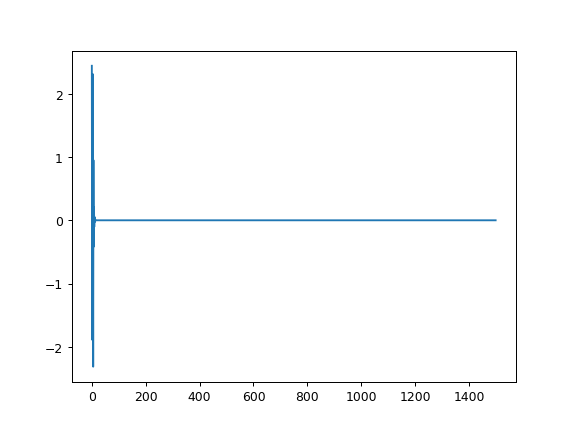

In [130]:
phases_sim = simulator.data['_x'][:,0]
angle_sim = np.arctan2(np.sin(phases_sim), np.cos(phases_sim))
plt.plot(simulator.data['_time'],angle_sim)

<IPython.core.display.Javascript object>


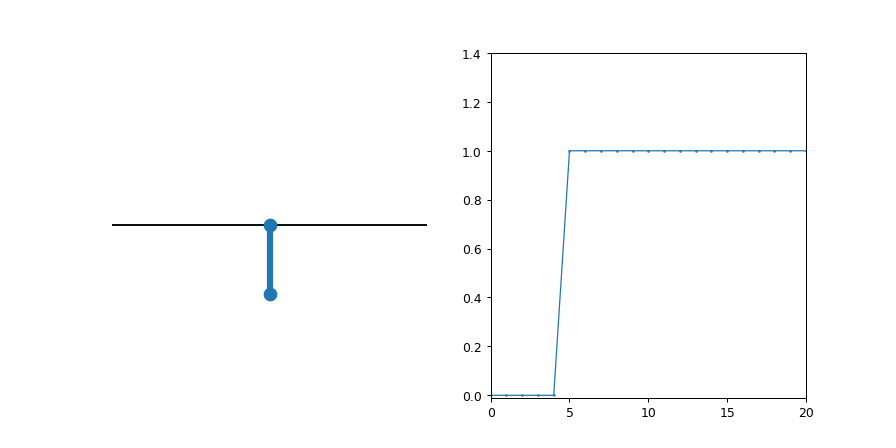

In [131]:
def _pendulum_with_mass(x, L1):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([0,L1 * np.sin(x[0])])
    line_1_y = np.array([0,-L1 * np.cos(x[0])])
    line_1 = np.stack((line_1_x, line_1_y))
    return line_1

def animate_(simulator,save,name):
    
    # The function describing the gif:
    time = simulator.data['_time'].flatten()
    x_arr = simulator.data._x
    u_arr = simulator.data._u
    friction = simulator.data._tvp.flatten()
    
    
    fig,ax = plt.subplots(1,2,figsize=(10, 5))
    # First axis
    ax[0].axhline(0, color='black')
    bar1 = ax[0].plot([], [], '-o', linewidth=5, markersize=10)
    ax[0].set_xlim(-2.5, 2.5)
    ax[0].set_ylim(-2.5, 2.5)
    ax[0].set_axis_off()
    
    
    data1 = ax[1].plot([], [], '-o', linewidth=1, markersize=1)
    ax[1].set_xlim(-0.01, 20)
    ax[1].set_ylim(-0.01, 1.4)
    #x[0].align_ylabels()
    #x[0].tight_layout()
    


    def update(t_ind):
        line1 = _pendulum_with_mass(x_arr[t_ind],l)
        bar1[0].set_data(line1[0], line1[1])
        
        data1[0].set_data(time[0:t_ind], friction[0:t_ind])
              

    anim = FuncAnimation(fig, update, frames=len(x_arr), repeat=False, interval=10)
    if save:
        anim.save(name + '_animation.gif', writer='pillow', fps=100)
    else:
        plt.show()
    return anim

animation = animate_(simulator,False,'')

# Now trying to reverse engineer the friction coefficient using a PINN

In [132]:
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools

In [133]:
class Pendulum_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh(),l1_init = 0.1):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        
        # Register the other paramter
        #self.l1 = nn.Parameter(torch.tensor([l1_init], requires_grad=True).float())
        #self.register_parameter("l1",self.l1)
    
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
PINN = Pendulum_approximator(2,2)

In [134]:
class Friction_approximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out
    
Fapprox = Friction_approximator(2,3)

In [135]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [167]:
def compute_loss(nn,rr,x,t_data,f_data):
    de_loss = m*l*df(nn,x,2) - (-m*g*torch.sin(nn(x)) - rr(x)*l*df(nn,x,1))
    bc_loss = f(nn,t_data) - f_data.view(-1,1)
    ic_loss = df(nn,torch.tensor([[0.0]],requires_grad = True),1) - init_vel
    final_loss = 0*de_loss.pow(2).mean()+ bc_loss.pow(2).mean() + 0*ic_loss.pow(2).mean()
    return final_loss

In [168]:
def optimise(optimiser,nn,rr,t_col,t_data,f_data):
    optimiser.zero_grad()
    loss = compute_loss(nn,rr,t_col,t_data,f_data)
    loss.backward()
    optimiser.step()
    return loss


In [177]:
lr = 0.01
epochs = 200000
PINN = Pendulum_approximator(2,50)
F_approx = Friction_approximator(2,3)
learnable_params = list(PINN.parameters()) # + list(F_approx.parameters())
pi_optimizer = Adam(learnable_params, lr=lr)

In [178]:
t_boundary = torch.from_numpy(simulator.data['_time']/1500.0).float()
f_boundary = torch.from_numpy(simulator.data['_x'][:,0]).float()
f_boundary = torch.sin(2*np.pi*t_boundary*1500.0/100).float()
t_collocation =  t_boundary
t_collocation.requires_grad = True

In [179]:
t_boundary.size()[0]

1500

In [180]:
batch_size = 128*4
loss_vector = []
iteration_vector =[]
for i in range(4000):
    print(f"Epoch {i}")
    permutation = torch.randperm(t_boundary.size()[0])
    for j in range(0,t_boundary.size()[0],batch_size):
        indices = permutation[j:j+batch_size]
        loss = optimise(pi_optimizer,PINN,F_approx,t_collocation[indices],t_boundary[indices],f_boundary[indices])
    iteration_vector.append(i)
    loss_vector.append(loss.detach().numpy())

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
Epoch 930
Epoch 931
Epoch 932
Epoch 933
Epoch 934
Epoch 935
Epoch 936
Epoch 937
Epoch 938
Epoch 939
Epoch 940
Epoch 941
Epoch 942
Epoch 943
Epoch 944
Epoch 945


Epoch 1606
Epoch 1607
Epoch 1608
Epoch 1609
Epoch 1610
Epoch 1611
Epoch 1612
Epoch 1613
Epoch 1614
Epoch 1615
Epoch 1616
Epoch 1617
Epoch 1618
Epoch 1619
Epoch 1620
Epoch 1621
Epoch 1622
Epoch 1623
Epoch 1624
Epoch 1625
Epoch 1626
Epoch 1627
Epoch 1628
Epoch 1629
Epoch 1630
Epoch 1631
Epoch 1632
Epoch 1633
Epoch 1634
Epoch 1635
Epoch 1636
Epoch 1637
Epoch 1638
Epoch 1639
Epoch 1640
Epoch 1641
Epoch 1642
Epoch 1643
Epoch 1644
Epoch 1645
Epoch 1646
Epoch 1647
Epoch 1648
Epoch 1649
Epoch 1650
Epoch 1651
Epoch 1652
Epoch 1653
Epoch 1654
Epoch 1655
Epoch 1656
Epoch 1657
Epoch 1658
Epoch 1659
Epoch 1660
Epoch 1661
Epoch 1662
Epoch 1663
Epoch 1664
Epoch 1665
Epoch 1666
Epoch 1667
Epoch 1668
Epoch 1669
Epoch 1670
Epoch 1671
Epoch 1672
Epoch 1673
Epoch 1674
Epoch 1675
Epoch 1676
Epoch 1677
Epoch 1678
Epoch 1679
Epoch 1680
Epoch 1681
Epoch 1682
Epoch 1683
Epoch 1684
Epoch 1685
Epoch 1686
Epoch 1687
Epoch 1688
Epoch 1689
Epoch 1690
Epoch 1691
Epoch 1692
Epoch 1693
Epoch 1694
Epoch 1695
Epoch 1696

Epoch 2366
Epoch 2367
Epoch 2368
Epoch 2369
Epoch 2370
Epoch 2371
Epoch 2372
Epoch 2373
Epoch 2374
Epoch 2375
Epoch 2376
Epoch 2377
Epoch 2378
Epoch 2379
Epoch 2380
Epoch 2381
Epoch 2382
Epoch 2383
Epoch 2384
Epoch 2385
Epoch 2386
Epoch 2387
Epoch 2388
Epoch 2389
Epoch 2390
Epoch 2391
Epoch 2392
Epoch 2393
Epoch 2394
Epoch 2395
Epoch 2396
Epoch 2397
Epoch 2398
Epoch 2399
Epoch 2400
Epoch 2401
Epoch 2402
Epoch 2403
Epoch 2404
Epoch 2405
Epoch 2406
Epoch 2407
Epoch 2408
Epoch 2409
Epoch 2410
Epoch 2411
Epoch 2412
Epoch 2413
Epoch 2414
Epoch 2415
Epoch 2416
Epoch 2417
Epoch 2418
Epoch 2419
Epoch 2420
Epoch 2421
Epoch 2422
Epoch 2423
Epoch 2424
Epoch 2425
Epoch 2426
Epoch 2427
Epoch 2428
Epoch 2429
Epoch 2430
Epoch 2431
Epoch 2432
Epoch 2433
Epoch 2434
Epoch 2435
Epoch 2436
Epoch 2437
Epoch 2438
Epoch 2439
Epoch 2440
Epoch 2441
Epoch 2442
Epoch 2443
Epoch 2444
Epoch 2445
Epoch 2446
Epoch 2447
Epoch 2448
Epoch 2449
Epoch 2450
Epoch 2451
Epoch 2452
Epoch 2453
Epoch 2454
Epoch 2455
Epoch 2456

Epoch 3119
Epoch 3120
Epoch 3121
Epoch 3122
Epoch 3123
Epoch 3124
Epoch 3125
Epoch 3126
Epoch 3127
Epoch 3128
Epoch 3129
Epoch 3130
Epoch 3131
Epoch 3132
Epoch 3133
Epoch 3134
Epoch 3135
Epoch 3136
Epoch 3137
Epoch 3138
Epoch 3139
Epoch 3140
Epoch 3141
Epoch 3142
Epoch 3143
Epoch 3144
Epoch 3145
Epoch 3146
Epoch 3147
Epoch 3148
Epoch 3149
Epoch 3150
Epoch 3151
Epoch 3152
Epoch 3153
Epoch 3154
Epoch 3155
Epoch 3156
Epoch 3157
Epoch 3158
Epoch 3159
Epoch 3160
Epoch 3161
Epoch 3162
Epoch 3163
Epoch 3164
Epoch 3165
Epoch 3166
Epoch 3167
Epoch 3168
Epoch 3169
Epoch 3170
Epoch 3171
Epoch 3172
Epoch 3173
Epoch 3174
Epoch 3175
Epoch 3176
Epoch 3177
Epoch 3178
Epoch 3179
Epoch 3180
Epoch 3181
Epoch 3182
Epoch 3183
Epoch 3184
Epoch 3185
Epoch 3186
Epoch 3187
Epoch 3188
Epoch 3189
Epoch 3190
Epoch 3191
Epoch 3192
Epoch 3193
Epoch 3194
Epoch 3195
Epoch 3196
Epoch 3197
Epoch 3198
Epoch 3199
Epoch 3200
Epoch 3201
Epoch 3202
Epoch 3203
Epoch 3204
Epoch 3205
Epoch 3206
Epoch 3207
Epoch 3208
Epoch 3209

Epoch 3873
Epoch 3874
Epoch 3875
Epoch 3876
Epoch 3877
Epoch 3878
Epoch 3879
Epoch 3880
Epoch 3881
Epoch 3882
Epoch 3883
Epoch 3884
Epoch 3885
Epoch 3886
Epoch 3887
Epoch 3888
Epoch 3889
Epoch 3890
Epoch 3891
Epoch 3892
Epoch 3893
Epoch 3894
Epoch 3895
Epoch 3896
Epoch 3897
Epoch 3898
Epoch 3899
Epoch 3900
Epoch 3901
Epoch 3902
Epoch 3903
Epoch 3904
Epoch 3905
Epoch 3906
Epoch 3907
Epoch 3908
Epoch 3909
Epoch 3910
Epoch 3911
Epoch 3912
Epoch 3913
Epoch 3914
Epoch 3915
Epoch 3916
Epoch 3917
Epoch 3918
Epoch 3919
Epoch 3920
Epoch 3921
Epoch 3922
Epoch 3923
Epoch 3924
Epoch 3925
Epoch 3926
Epoch 3927
Epoch 3928
Epoch 3929
Epoch 3930
Epoch 3931
Epoch 3932
Epoch 3933
Epoch 3934
Epoch 3935
Epoch 3936
Epoch 3937
Epoch 3938
Epoch 3939
Epoch 3940
Epoch 3941
Epoch 3942
Epoch 3943
Epoch 3944
Epoch 3945
Epoch 3946
Epoch 3947
Epoch 3948
Epoch 3949
Epoch 3950
Epoch 3951
Epoch 3952
Epoch 3953
Epoch 3954
Epoch 3955
Epoch 3956
Epoch 3957
Epoch 3958
Epoch 3959
Epoch 3960
Epoch 3961
Epoch 3962
Epoch 3963

<IPython.core.display.Javascript object>


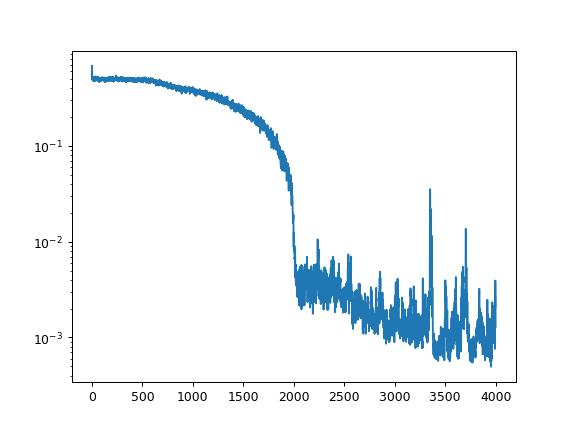

In [181]:
plt.figure()
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

<IPython.core.display.Javascript object>


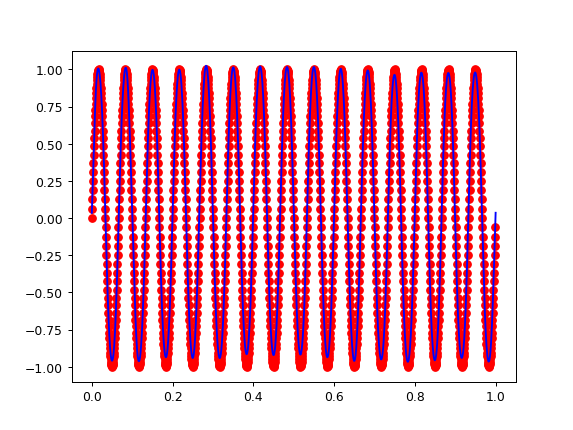

In [182]:
plt.figure()
t_data_domain = torch.linspace(0, 1, steps=1500).view(-1, 1)
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()
    

plt.plot(t_boundary.detach().numpy(),f_boundary.detach().numpy(),'or')
plt.plot(t_data_domain,f_prediction,'b-')

<IPython.core.display.Javascript object>


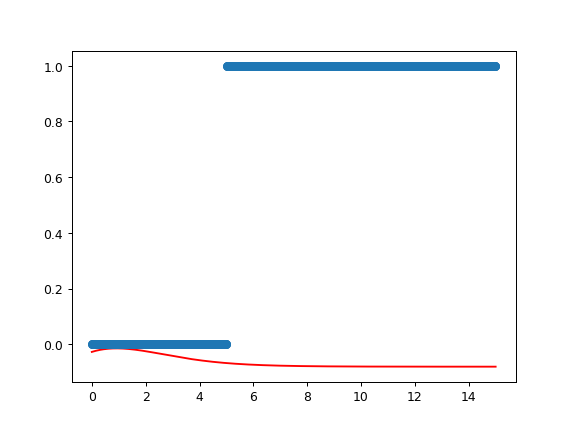

In [21]:
plt.figure()
# NOw interrogate the R approximator
t_data_domain = torch.linspace(0, 15, steps=1000).view(-1, 1)
with torch.no_grad():
    r_prediction = F_approx(t_data_domain).numpy()

plt.plot(t_data_domain,r_prediction,'r')
plt.plot( simulator.data._time, simulator.data._tvp.flatten(),'o')